<a href="https://colab.research.google.com/github/andreavittino/colab_notebooks/blob/main/Temperature_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We consider here a weather forecasting problem, where we consider a time series of 14 quantities measured every 10 minutes in the 2009-2016 period. We will try to preict the temperature for 24 hours after the last data points by using RNN. 

What we do here is largely based on Chap. 6 of the book "Deep learning with Python" by F. Chollet

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2020-10-22 17:35:10--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.80.246
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.80.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.3’

jena_climate_2009_2 100%[===================>]  12.94M  17.9MB/s    in 0.7s    

2020-10-22 17:35:11 (17.9 MB/s) - ‘jena_climate_2009_2016.csv.zip.3’ saved [13568290/13568290]



In [ ]:
import os 
import zipfile
local_zip = 'jena_climate_2009_2016.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
fname = 'jena_climate_2009_2016.csv'
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [ ]:
# parsing the data
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]] 
  float_data[i, :] = values

In [ ]:
float_data.shape

(420551, 14)

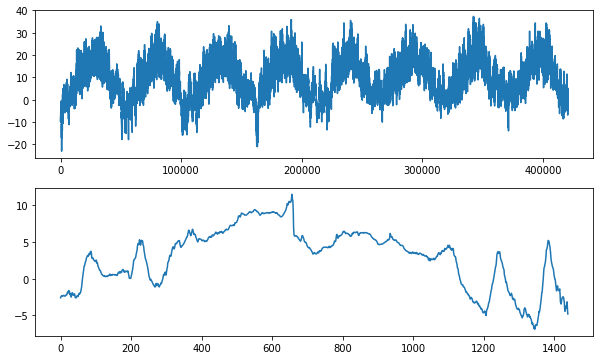

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(10,6))
temp = float_data[:,1]
ax[0].plot(range(len(temp)),temp) # full dataset
ax[1].plot(range(1440),temp[-1440:]) # last ten days

In [ ]:
train_size = 200000
train_set = float_data[0:train_size]
train_mean = train_set.mean(axis=0)
train_std = train_set.std(axis=0)

In [ ]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index)) 
      i += len(rows)
    samples = np.zeros((len(rows), lookback // step,data.shape[-1])) 
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step) 
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [ ]:
float_data = (float_data - train_mean)/train_std
lookback = 1440 #observations go back 5 days
step = 6   #temperatures are sampled every hour
delay = 144 #targets are 24 hours in the future
batch_size = 128
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step,batch_size=batch_size)
val_gen = generator(float_data,lookback=lookback,delay=delay, min_index=200001,max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None,step=step, batch_size=batch_size)
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

# A non-machine learning baseline
Before applying any machine learning framework, we focus on a very simple, non-machine learning approach, which will represent our baseline. This simple model is based on the assumption that the temperature is periodic, with a 24-hour period.

In [ ]:
"""
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets)) 
    batch_maes.append(mae)
  print(np.mean(batch_maes)) 
evaluate_naive_method()
"""

'\ndef evaluate_naive_method():\n  batch_maes = []\n  for step in range(val_steps):\n    samples, targets = next(val_gen)\n    preds = samples[:, -1, 1]\n    mae = np.mean(np.abs(preds - targets)) \n    batch_maes.append(mae)\n  print(np.mean(batch_maes)) \nevaluate_naive_method()\n'

The method above gives a mean average error of 0.29, which we can translate back into degrees (by taking into account how we have rescaled temperatures to have mean 0 and standard deviation 1)

In [ ]:
#celsius_mae = 0.29 * train_std[1]
#print(celsius_mae)

In [ ]:
import tensorflow as tf 
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])),
                                    tf.keras.layers.Dense(32,activation='relu'),
                                    tf.keras.layers.Dense(1)
])                                  

In [ ]:
model.compile(optimizer='adam',loss='mae')
history = model.fit(train_gen,
                              steps_per_epoch = 500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 795s 2s/step - loss: 0.4976 - val_loss: 0.3768
Epoch 2/20
500/500 [==============================] - 775s 2s/step - loss: 0.3044 - val_loss: 0.3352
Epoch 3/20
500/500 [==============================] - 766s 2s/step - loss: 0.2425 - val_loss: 0.3233
Epoch 4/20
500/500 [==============================] - 785s 2s/step - loss: 0.2188 - val_loss: 0.3232
Epoch 5/20
500/500 [==============================] - 772s 2s/step - loss: 0.2021 - val_loss: 0.3223
Epoch 6/20
500/500 [==============================] - 809s 2s/step - loss: 0.1918 - val_loss: 0.3234
Epoch 7/20
500/500 [==============================] - 758s 2s/step - loss: 0.1845 - val_loss: 0.3332
Epoch 8/20
500/500 [==============================] - 748s 1s/step - loss: 0.1780 - val_loss: 0.3347
Epoch 9/20
500/500 [==============================] - 748s 1s/step - loss: 0.1736 - val_loss: 0.3436
Epoch 10/20
500/500 [==============================] - 740s 1s/step - loss: 0.1693 - val_lo